In [1]:
from datetime import datetime, timedelta
import pickle
import copy

from package.query import *
from package.plot import *
from package.data_mgt import *
from package.seriealize import *
from package.dic_mgt import *
from package.data import *

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34588, 34752, 34701, 34865, 34813, 34976, 34924', '34593, 34544, 34709, 34660, 34825, 34776, 34941', '34963, 35158, 35008, 35273, 35589, 35784, 35634', '34783, 34682, 35130, 35326, 35519, 35789, 36053', '34738, 33847, 34395, 35346, 34998, 35644, 36384', '34539, 34589, 34804, 34854, 34909, 34918, 35050', '34426, 33995, 34131, 34558, 34594, 34741, 34542', '34610, 34824, 34813, 34927, 34955, 35038, 35095', '34753, 34812, 34929, 35101, 35245, 35322, 35493', '34698, 34785, 34424, 34230, 34031, 33858, 33925']
serialized list :  [[34588, 34752, 34701, 34865, 34813, 34976, 34924], [34593, 34544, 34709, 34660, 34825, 34776, 34941], [34963, 35158, 35008, 35273, 35589, 35784, 35634], [34783, 34682, 35130, 35326, 35519, 35789, 36053], [34738, 33847, 34395, 35346, 34998, 35644, 36384], [34539, 34589, 34804, 34854, 34909, 34918, 35050], [34426, 33995, 34131, 34558, 34594, 34741, 34542], [34610, 34824, 34813, 34927, 34955, 35038,

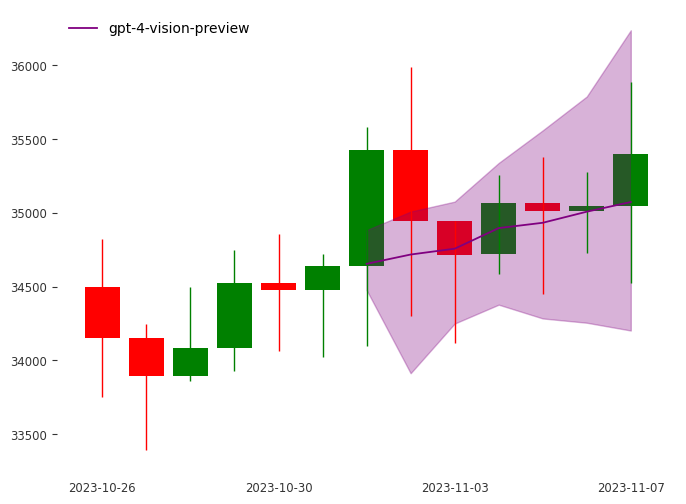

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34696, 34751, 34806, 34861, 34916, 34971, 35026', '34831, 34916, 35281, 35161, 35422, 35753, 35608', '34701, 34843, 34792, 34924, 34871, 35004, 34949', '34439, 33949, 34481, 35210, 35922, 36811, 37256', '34436, 34060, 34087, 34319, 34261, 34385, 34208', '34798, 34865, 34957, 35104, 35219, 35308, 35393', '34614, 34749, 34668, 34835, 34722, 34921, 34774', '34588, 34420, 34714, 34935, 34984, 35213, 35160', '34739, 35122, 35207, 35133, 35138, 35244, 35399', '34769, 34944, 35172, 35339, 35494, 35619, 35798']
serialized list :  [[34696, 34751, 34806, 34861, 34916, 34971, 35026], [34831, 34916, 35281, 35161, 35422, 35753, 35608], [34701, 34843, 34792, 34924, 34871, 35004, 34949], [34439, 33949, 34481, 35210, 35922, 36811, 37256], [34436, 34060, 34087, 34319, 34261, 34385, 34208], [34798, 34865, 34957, 35104, 35219, 35308, 35393], [34614, 34749, 34668, 34835, 34722, 34921, 34774], 

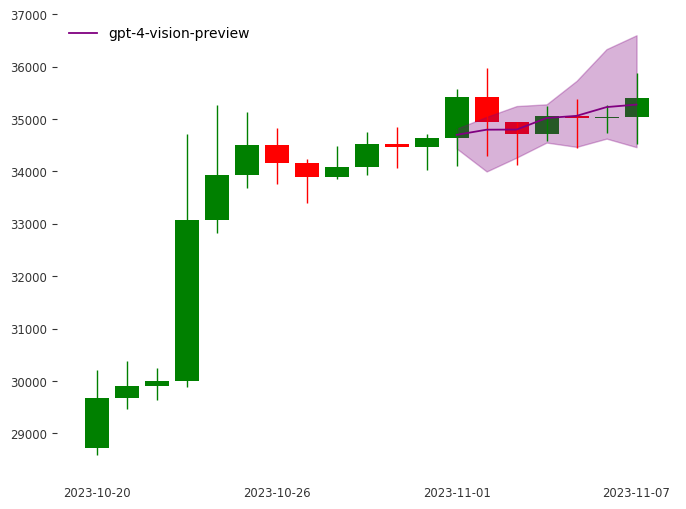

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34672, 34746, 34847, 34973, 35092, 35189, 35265', '34771, 34947, 35211, 35785, 36321, 36898, 37325', '34404, 34462, 33816, 33189, 33312, 32601, 32759', '35104, 35551, 36018, 36499, 36995, 37406, 37832', '34748, 35076, 35243, 34846, 34757, 34872, 34913', '34845, 35072, 35231, 35311, 35179, 35046, 35123', '34791, 34957, 35066, 35205, 35316, 35406, 35473', '34557, 34563, 34622, 34653, 34771, 34801, 34923', '34670, 34915, 35066, 35446, 35497, 35538, 35753', '34587, 34678, 34714, 34839, 35157, 36102, 36316']
serialized list :  [[34672, 34746, 34847, 34973, 35092, 35189, 35265], [34771, 34947, 35211, 35785, 36321, 36898, 37325], [34404, 34462, 33816, 33189, 33312, 32601, 32759], [35104, 35551, 36018, 36499, 36995, 37406, 37832], [34748, 35076, 35243, 34846, 34757, 34872, 34913], [34845, 35072, 352

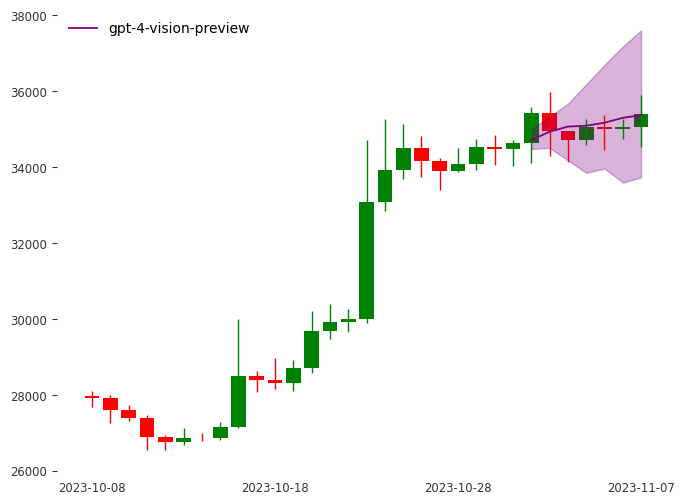

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34446, 34239, 34350, 34407, 34187, 33980, 33891', '34702, 34791, 34833, 34904, 34988, 35015, 35042', '34690, 34739, 34788, 34837, 34886, 34935, 34984', '34582, 34523, 34666, 34758, 34889, 35126, 35293', '34740, 34784, 34825, 34869, 34910, 34955, 34996', '34782, 34814, 34983, 35305, 35763, 35984, 36005', '34676, 34704, 34719, 34725, 34724, 34718, 34709', '34649, 34672, 34673, 34692, 34708, 34725, 34741', '34487, 34363, 34276, 34391, 34333, 34245, 34217', '34711, 34942, 35138, 35317, 35561, 35870, 36025']
serialized list :  [[34446, 34239, 34350, 34407, 34187, 33980, 33891], [34702, 34791, 34833, 34904, 34988, 35015, 35042], [34

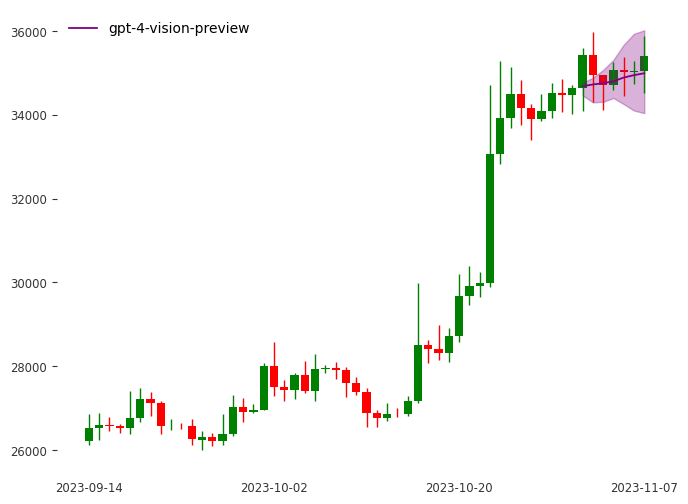

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34628, 34583, 34547, 34321, 34020, 33842, 33730', '34621, 34757, 34900, 34704, 34939, 35492, 35380', '34723, 34836, 35014, 35123, 35268, 35422, 35589', '34567, 34534, 34403, 34838, 34591, 34559, 34854', '34618, 34595, 34572, 34549, 34526, 34503, 34480', '34595, 34718, 34658, 34684, 34722, 34600, 3

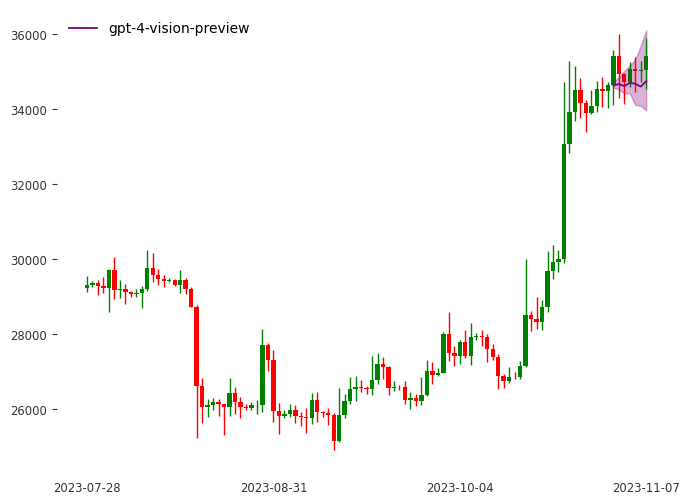

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

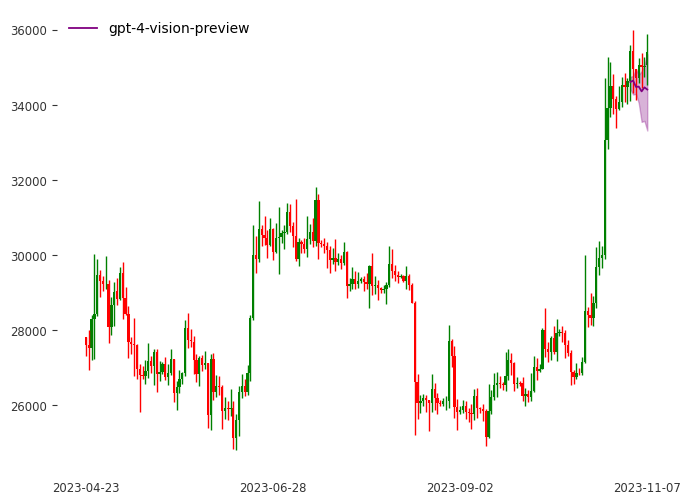

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_naive_bitcoin.pkl
pickle/dic_error_naive_bitcoin_median.pkl


In [2]:
data = bitcoin_data( mode = "naive")
make_prediction(data)

In [3]:
all_naive_dic = make_dic_MAE_MSE(path1="pickle/dic_error_naive_bitcoin.pkl", path2 = pickle/dic_error_naive_bitcoin_median.pkl)

dic_error :
{'input_length': {6: {'Mae': [[539.1311324621565, 229.5613064233694, 898.879542611663, 502.9447514835265, 718.0535351700019, 927.096726418742, 861.2234133746533], [660.1311324621565, 236.4386935766306, 216.87954261166306, 172.9447514835265, 165.05353517000185, 319.09672641874204, 190.22341337465332], [833.1311324621565, 189.4386935766306, 114.12045738833694, 422.0552485164735, 284.94646482999815, 358.90327358125796, 640.7765866253467], [639.1311324621565, 243.4386935766306, 437.87954261166306, 12.055248516473512, 396.05353517000185, 214.09672641874204, 265.2234133746533], [1271.1311324621565, 952.4386935766306, 641.120457388337, 543.0552485164735, 541.9464648299981, 410.90327358125796, 1249.7765866253467], [503.13113246215653, 164.5613064233694, 410.87954261166306, 343.9447514835265, 436.05353517000185, 665.096726418742, 311.2234133746533], [657.1311324621565, 232.5613064233694, 927.879542611663, 814.9447514835265, 1186.0535351700019, 1796.096726418742, 1729.2234133746533],

Traceback (most recent call last):
  File "/opt/anaconda3/envs/llmtime/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/kl/q1n_6x_s3k39xwq0lqh5ccsr0000gn/T/ipykernel_11171/2232772513.py", line 1, in <module>
    all_naive_dic = make_dic_MAE_MSE("naive")
  File "/Users/williammoiroud/Documents/nii/LLM-sandbox/package/dic_mgt.py", line 139, in make_dic_MAE_MSE
  File "/Users/williammoiroud/Documents/nii/LLM-sandbox/package/dic_mgt.py", line 49, in dic_mgt
    sub_list_5 = []
TypeError: string indices must be integers

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/llmtime/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/opt/anaconda3/envs/llmtime/lib/python3.9/site-packages/IPython/core/ultratb

In [4]:
display_tab(all_naive_dic)

Global MAE/MSE
Mean error with 3 days forecasting
  input_length      Mae     Mse
--------------  -------  ------
             6  479.982  326302
            12  373.357  214631
            24  498.702  392044
            48  452.897  264368
            96  442.669  276410
           192  688.447  611296
Mean error with 5 days forecasting
  input_length      Mae     Mse
--------------  -------  ------
             6  450.771  293349
            12  329.036  164216
            24  532.464  490829
            48  440.449  243987
            96  435.362  272941
           192  715.211  737205
Mean error with 7 days forecasting
  input_length      Mae     Mse
--------------  -------  ------
             6  495.086  383459
            12  337.208  167755
            24  610.81   650178
            48  471.86   294373
            96  465.37   330249
           192  746.431  848907
##############################
Median MAE/MSE
Median error with 3 days forecasting
  input_length      Mae     M

Input str :  -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['107, -63, 80, 23, -92, 72, -52', '212, 243, 107, 291, 390, 211, 548', '86, 67, -71, -84, 88, 107, -56', '-121, -70, 71, 142, -30, 96, -142', '69, -144, 171, -39, 192, 3, 213', '85, -136, 171, -204, 220, -253, 279', '149, -36, 68, 203, -49, 104, 287', '117, -31, 97, 108, -46, 88, 100', '163, -191, 524, -1159, 2772, -6587, 15730', '102, 145, -35, 68, 192, 203, -55']
int list return
[[107, -63, 80, 23, -92, 72, -52], [212, 243, 107, 291, 390, 211, 548], [86, 67, -71, -84, 88, 107, -56], [-121, -70, 71, 142, -30, 96, -142], [69, -144, 171, -39, 192, 3, 213], [85, -136, 171, -204, 220, -253, 279], [149, -36, 68, 203, -49, 104, 287], [117, -31, 97, 108, -46, 88, 100], [163, -191, 524, -1159, 2772, -6587, 15730], [102, 145, -35, 68, 192, 203, -55]]
int list, close
[[35011.39465005757, 34790.82286376221, 35069.14944667231, 35149.80849039966, 34826.43025228798, 35077.18055010446, 34894.77921124391], [35375.12240688513, 36234.73788137243

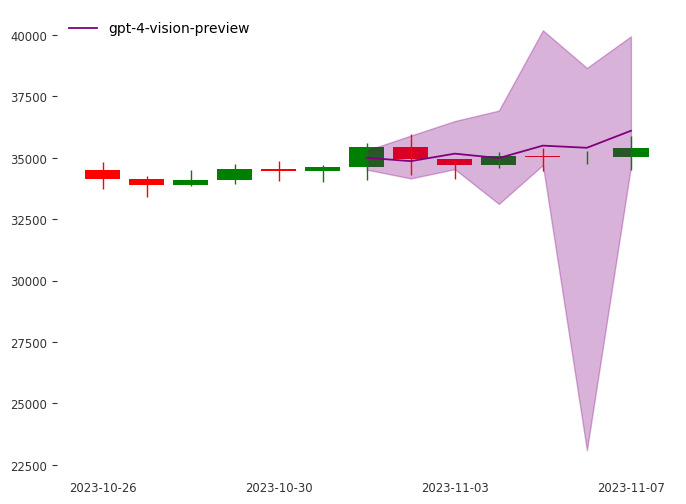

Input str :  333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-272, 164, 680, -226, -340, 1364, -454', '125, -98, 108, 119, -121, 68, 113', '59, -1, 40, 67, 17, 32, 75', '-9, 20, -3, 8, -1, 4, -1', '54, 117, -12, 45, 60, 108, -9', 'Sorry, but I am unable to provide the continuation of the sequence without additional context or information on the pattern or rule governing the progression of the numbers given in the sequence.', '106, -3, 63, -89, 81, -5, 70', '-26, 33, -9, 24, -2, 15, 6', '-7, 176, 370, -72, -20, 50, 65', '-84, -14, 62, 125, -29, 40, -98']
error in serialization
int list return
[[-272, 164, 680, -226, -340, 1364, -454], [125, -98, 108, 119, -121, 68, 113], [59, -1, 40, 67, 17, 32, 75], [-9, 20, -3, 8, -1, 4, -1], [54, 117, -12, 45, 60, 108, -9], [106, -3, 63, -89, 81, -5, 70], [-26, 33, -9, 24, -2, 15, 6], [-7, 176, 370, -72, -20, 50, 65], [-84, -14, 62, 125, -29, 40, -98]]
int list, close
[[33698.51065160385, 34251.16622629015, 36580.2455296778

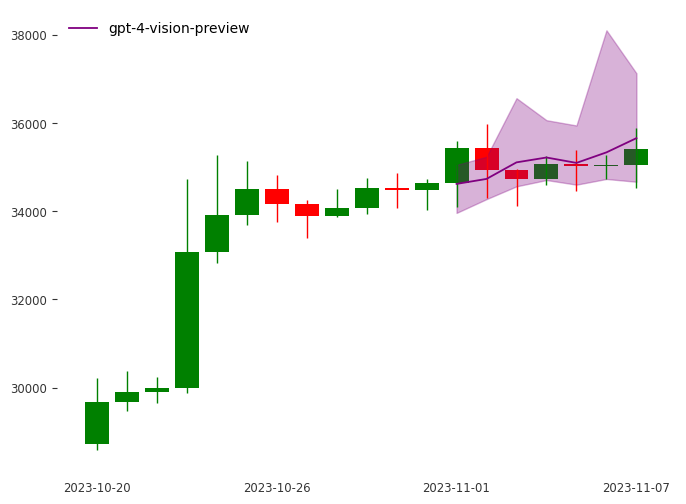

Input str :  -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['237, -66, -45, 170, 411, 114, 73', '383, -74, -10, 167, 294, 101, 71', '117, 604, 63, 76, 361, 898, 147', '327, -29, 15, 87, 219, -7, 22', '213, 702, 604, 506, 408, 310, 212', '637, 631, 1019, 370, 1187, 881, 1359', '74, -615, -172, -57, 307, 873, 204', '46, 37, 168, 262, 91, 63, 1135', '155, -33, 176, 59, -2, 63, 179', '892, -38, -19, 113, 243, 72, 49']
int list return
[[237, -66, -45, 170, 411, 114, 73], [383, -74, -10, 167, 294, 101, 71], [117, 604, 63, 76, 361, 898, 147], [327, -29, 15, 87, 219, -7, 22], [213, 702, 604, 506, 408, 310, 212], [637, 631, 1019, 370, 1187, 881, 1359], [74, -615, -172, -57, 307, 873, 204], [46, 37, 168, 262, 91, 63, 1135], [155, -33, 176, 59, -2, 63, 179], [892, -38, -19, 113, 243, 72, 49]]
int list, close
[[35461.72425374883, 35227.676873674085, 35069.15232774255, 35665.32791731417, 37131.17289471578, 37554.

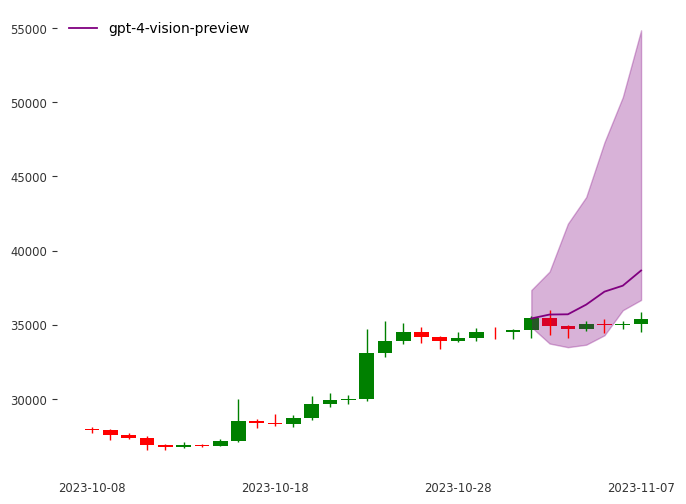

Input str :  115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-149, -10, -190, 267, 55, 84, 1498', '-50, 25, 936, 309, 151, -69, -123', '311, -342, 85, 2027, 560, -82, 320', '-310, 328, 219, 57, -49, -231, -78', '-177, -263, -74, 215, 494, 172, 57', '-22, -38, -189, 11, 35, -8, 216', 'Please provide the pattern to the sequence for further assistance.', '-244, -35, -41, 228, 314, -208, 88', '233, -214, -29, 158, -121, 220, 25', '-287, -13, -70, 197, 579, 168, 62']
error in serialization
int list return
[[-149, -10, -190, 267, 55, 84, 1498], [-50, 25, 936, 309, 151, -69, -123], [311, -342, 85, 2027, 560, -82, 320], [-310, 328, 219, 57, -49, -231, -78], [-177, -263, -74, 215, 494, 172, 57], [-22, -38, -189, 11, 35, -8, 216], [-244, -35, -41, 228, 314, -208, 88], [233, -214, -29, 158, -121, 22

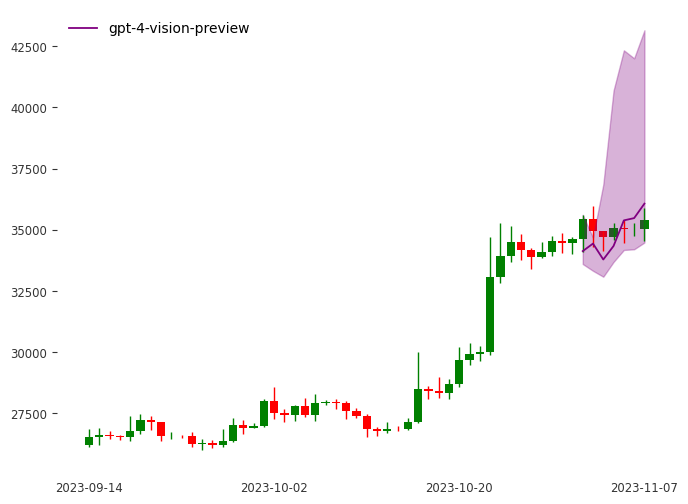

Input str :  31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-472, 63, -387, -84, 32, 48, -65', '-8, -11, 159, -109, 103, 298, -174', '-76, -28, 48, 19, -79, 161, -322', '66, -2, 20, 56, 432, 181, 251', '-98, -624, -74, 18, 85, 412, 19', '-57, 29, 65, -38, -104, 328, -205', '-215, -6, 166, 269, 218, -140, 29', '-173, -230, 602, 730, 287, 9, 135', '-13, 111, -76, -7, 40, -101, -225', '-116, -44, 31, 237, 412, 116, -3']
int list return
[[-472, 63, -387, -84, 32, 48, -65], [-8, -11, 159, -109, 103, 298, -174], [-76, -28, 48, 19, -79, 161, -322], [66, -2, 20, 56, 432

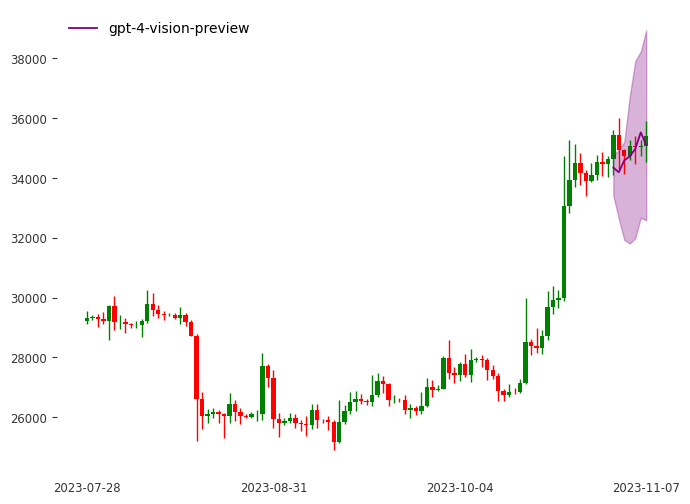

Input str :  -81, -29, 287, 41, 372, -55, -28, 1, -399, 214, 124, -65, 232, -222, -145, -268, -15, -11, -228, -64, -8, 53, 91, -47, 137, -213, 22, 83, -131, 38, 138, -327, 55, 88, 56, 451, -117, -15, -175, -144, 158, -64, 17, -511, 584, -327, 61, -8, -240, 33, -8, 11, -311, 187, 292, 65, -67, 192, 545, 596, -37, 269, -52, -21, -64, 140, -200, 123, 8, 37, 10, 176, -125, -85, -199, 150, -20, -41, 83, 69, -79, 354, -363, -7, -19, -31, -92, 17, -37, 34, -36, 97, -302, 18, 42, -44, 31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-637, 23, -60, 263, -32, -263, 245', '-

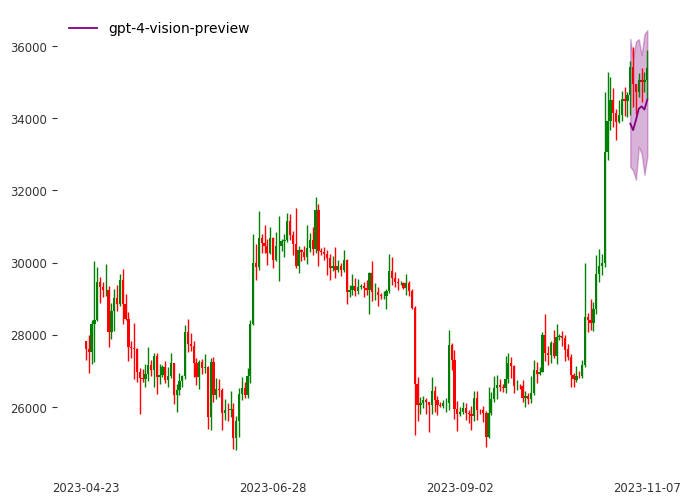

In [6]:
make_prediction(mode = "return", data = "bitcoin", setup = None, model = "gpt-4-vision-preview")

In [7]:
all_return_dic = make_dic_MAE_MSE("return")

dic_error :
{'input_length': {6: {'Mae': [[410.73648240458715, 150.6158298144219, 352.0289892839719, 86.75324188318336, 186.51621254201746, 31.27727652320027, 504.9973753814338], [47.00872557702678, 1293.2991877958048, 1905.3291193147816, 2625.107610868705, 4145.054746071197, 4938.3317628699515, 6775.5945298233855], [483.48203377009486, 231.29935407666198, 205.89115012661932, 433.3969385046439, 78.5471616900686, 262.2941021022634, 289.30511624565406], [1200.5453258015477, 959.4039875626477, 493.81330496165174, 353.7771345253277, 407.7961851808286, 108.5435512474578, 958.5273723486825], [542.3712896374127, 563.9473924885606, 248.22594494833902, 234.07369714890956, 484.7515323238258, 462.44403297171084, 864.8985175572016], [486.9461076446387, 481.37218509663217, 332.21318838666775, 728.7280091152788, 76.73597383802553, 843.9898006115327, 243.62972775976232], [265.24537967356446, 88.88227050191927, 551.406689245945, 921.4229991944812, 795.2078394671698, 1134.6558354805966, 1819.1645688665

In [8]:
display_tab(all_return_dic)

Global MAE/MSE
Mean error with 3 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6   537.739  481114
            12   580.489  589905
            24  1618.39        5.9629e+06
            48  1028.17        1.5461e+06
            96   978.952       1.63648e+06
           192  1450.37        2.62794e+06
Mean error with 5 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6   791.294       1.77566e+06
            12   510.473  460309
            24  2432.64        1.42283e+07
            48  1375.74        4.81213e+06
            96  1132.32        2.38633e+06
           192  1286.71        2.1798e+06
Mean error with 7 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6  1220.44        8.81467e+06
            12   592.212  777674
            24  3393.04        3.19334e+07
            48  1622

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, U2, D2, U2, D2, U2, D2', 'D2, U2, D2, U2, D2, U2, D2', 'D2, U2, D2, U2, D2, U2, D2', 'D2, U2, D2, U2, D2, U2, D2', 'D2, U2, D2, U2, D2, U2, D2', 'D2, U2, D2, U2, D2, U2, D2', 'D2, U2, D2, U2, D2, U2, D2', 'D2, U2, D2, U2, U4, D2, U2', 'D2, U2, D2, U2, D2, U2, D2', 'D2, U2, D2, D2, U2, U2, D2']
serialized :  [[-1, 1, -1, 1, -1, 1, -1], [-1, 1, -1, 1, -1, 1, -1], [-1, 1, -1, 1, -1, 1, -1], [-1, 1, -1, 1, -1, 1, -1], [-1, 1, -1, 1, -1, 1, -1], [-1, 1, -1, 1, -1, 1, -1], [-1, 1, -1, 1, -1, 1, -1], [-1, 1, -1, 1, 3, -1, 1], [-1, 1, -1, 1, -1, 1, -1], [-1, 1, -1, -1, 1, 1, -1]]
int list, close
[[34294, 34636, 34289, 34631, 34284, 34626, 34279], [34294, 34636, 34289, 34631, 34284, 34626, 34279], [34294, 34636, 34289, 34631, 34284, 34626, 34279], [34294, 34636, 34289, 34631, 34284, 34626, 34279], [34294, 34636, 34289, 34631, 34284, 34626, 34279], [34294, 34636, 34289, 34631, 34284, 34626, 34279], [34294, 34636, 34289, 

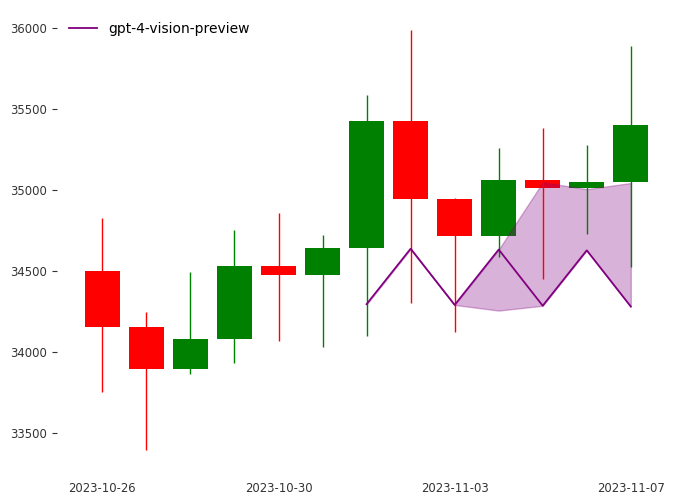

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, D4, U2, U2, U4, U4, U2', 'U2, U2, D2, D4, D2, U2, U2', 'D2, D4, D6, D8, D10, D10+, D10+', 'U2, U2, U4, U4, U4, U6, U6', 'D2, D4, D2, U2, U2, U2, U2', 'D2, D4, D6, D8, D10, D10+, D10+', 'D2, D4, D6, D8, D10, D10+, U2', 'U2, U2, U2, U2, U2, U2, U2', 'U2, U2, D2, D2, D4, D4, U2', 'U2, U2, U2, U2, U2, U2, U2']
serialized :  [[-1, -3, 1, 1, 3, 3, 1], [1, 1, -1, -3, -1, 1, 1], [-1, -3, -5, -7, -9, -11, -11], [1, 1, 3, 3, 3, 5, 5], [-1, -3, -1, 1, 1, 1, 1], [-1, -3, -5, -7, -9, -11, -11], [-1, -3, -5, -7, -9, -11, 1], [1, 1, 1, 1, 1, 1, 1], [1, 1, -1, -1, -3, -3, 1], [1, 1, 1, 1, 1, 1, 1]]
int list, close
[[34294, 33265, 33597, 33932, 34949, 35997, 36356], [34987, 35336, 34982, 33932, 33592, 33927, 34266], [34294, 33265, 31601, 29388, 26743, 23801, 21182], [34987, 35336, 36396, 37487, 38611, 40541, 42568], [34294, 33265, 32932, 33261, 33593, 33928, 34267], [34294, 33265, 31601

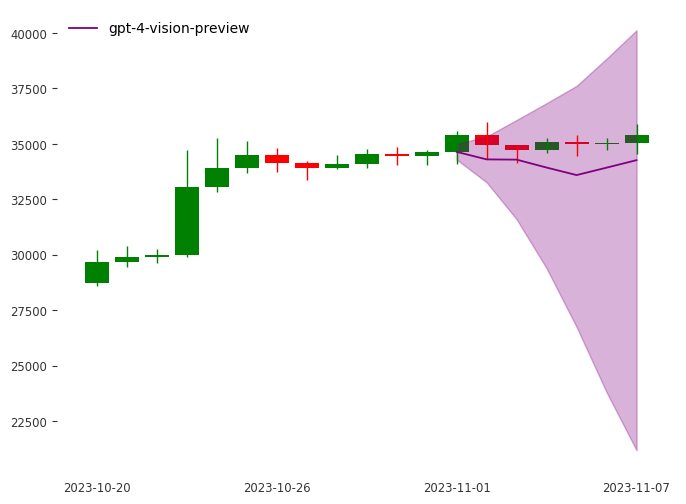

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, U2, U2, D2, D4, D2, U2', 'U2, D2, D2, D2, U2, U2, U2', 'D2, D2, U2, U2, U2, U2, U2', 'U2, U2, U4, U4, U2, U2, U2', 'U2, U2, U4, U2, U2, D2, D2', 'U2, U2, U2, U2, U2, U2, U2', 'D2, D2, D2, D2, D2, D2, D2', 'D2, D2, D4, D2, U2, U2, U4', 'D2, U2, D4, D2, U4, U2, U4', 'U2, U4, U2, U4, U6, U8, U10']
serialized :  [[-1, 1, 1, -1, -3, -1, 1], [1, -1, -1, -1, 1, 1, 1], [-1, -1, 1, 1, 1, 1, 1], [1, 1, 3, 3, 1, 1, 1], [1, 1, 3, 1, 1, -1, -1], [1, 1, 1, 1, 1, 1, 1], [-1, -1, -1, -1, -1, -1, -1], [-1, -1, -3, -1, 1, 1, 3], [-1, 1, -3, -1, 3, 1, 3], [1, 3, 1, 3, 5, 7, 9]]
int list, close
[[34294, 34636, 34982, 34632, 33593, 33257, 33589], [34987, 34637, 34290, 33947, 34286, 34628, 34974], [34294, 33951, 34290, 34632, 34978, 35327, 35680], [34987, 35336, 36396, 37487, 37861, 38239, 38621], [34987, 353

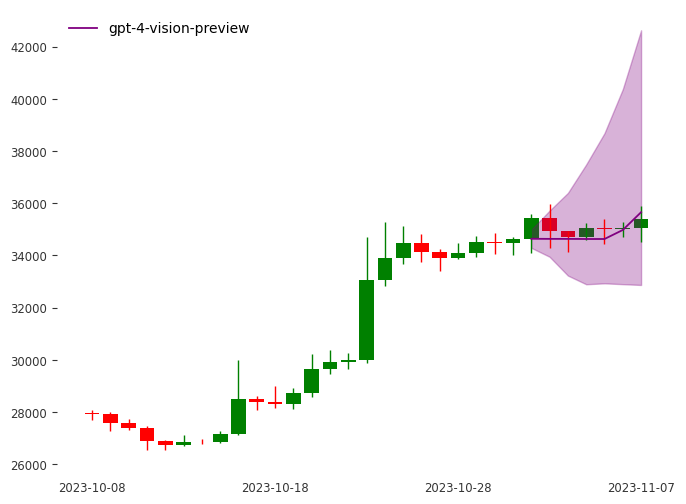

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, D2, D4, D6, D8, D10, D10+', 'D2, D4, D6, D8, D10, D10+, D10+', 'U2, U2, U2, U4, U4, U6, U6', 'D2, D2, U2, U2, U2, U4, U4', 'U2, U4, U6, U8, D2, D4, D6', 'U2, U2, D2, D4, D4, D6, D8', 'U2, U2, D2, D4, D6, D8, D10', 'U2, U4, U6, U8, U10, U10+, U10+', 'D2, D2, D4, D6, D8, D10, D10+', 'U2, U2, D2, D4, D2, U2, U4']
serialized :  [[1, -1, -3, -5, -7, -9, -11], [-1, -3, -5, -7, -9, -11, -11], [1, 1, 1, 3, 3, 5, 5], [-1, -1, 1, 1, 1, 3, 3], [1, 3, 5, 7, -1, -3, -5], [1, 1, -1, -3, -3, -5, -7], [1, 1, -1, -3, -5, -7, -9], [1, 3, 5, 7, 9, 11, 11], [-1, -1, -3, -5, -7, -9, -11], [1, 1, -1, -3, -1, 1, 3]]
int list, close
[[34987, 3463

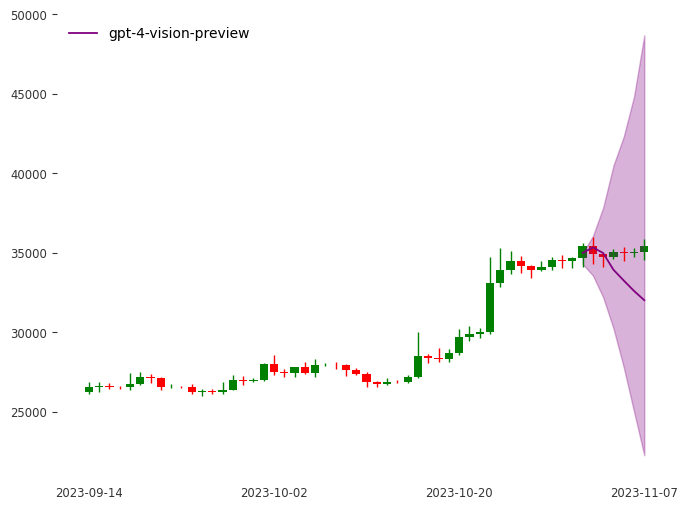

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U4, U2, D2, D4, D6, D8, D10', 'U10+, U10+, U10+, U10+, U10+, U10+, U10+', 'U10+, U10+, U10+, U10+, U10+, U10+, U10+', 'D2, D4, D6, D8, D10, D10+, D10+', 'U10+, U10+, U10+, U10+, U10+, U10+, U10+', 'U2, U2, U2, U2, U2, U2, U2', 'D2, D4, D4, D2, D2, D4, D4', 'D2, D4, D6, D8, D10, D10+, D10+', 'D2, D

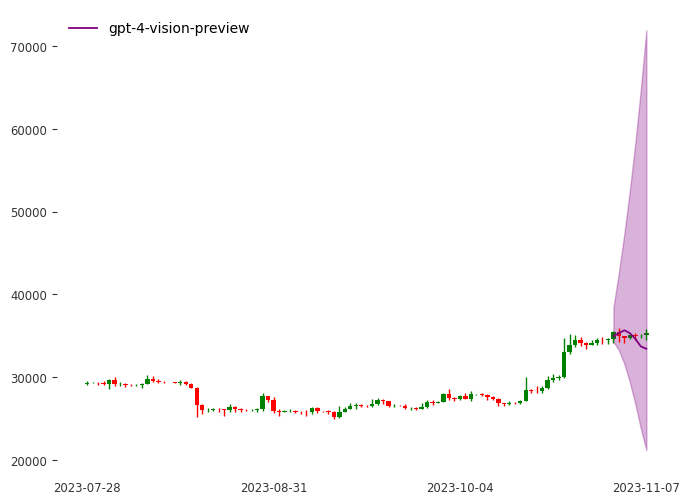

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

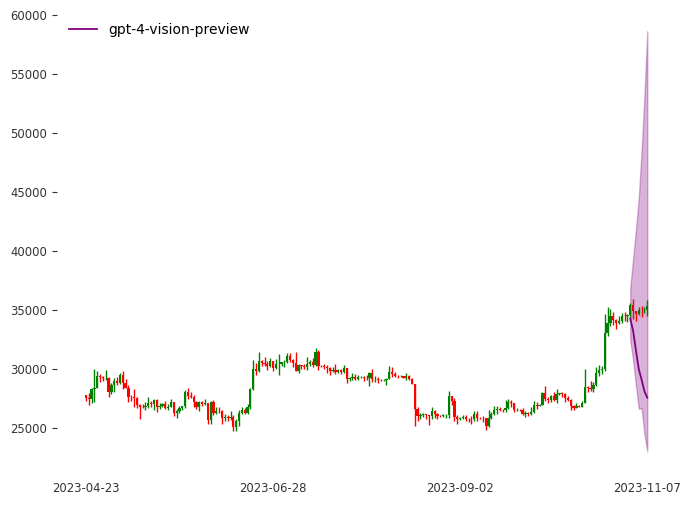

In [3]:
make_prediction(mode = "bin", data = "bitcoin", setup = None, model = "gpt-4-vision-preview")

In [4]:
all_bin_dic = make_dic_MAE_MSE("bin")

dic_error :
{'input_length': {6: {'Mae': [[1128.1311324621565, 305.4386935766306, 428.12045738833694, 432.0552485164735, 728.9464648299981, 419.90327358125796, 1120.7765866253467], [1128.1311324621565, 305.4386935766306, 428.12045738833694, 432.0552485164735, 728.9464648299981, 419.90327358125796, 1120.7765866253467], [1128.1311324621565, 305.4386935766306, 428.12045738833694, 432.0552485164735, 728.9464648299981, 419.90327358125796, 1120.7765866253467], [1128.1311324621565, 305.4386935766306, 428.12045738833694, 432.0552485164735, 728.9464648299981, 419.90327358125796, 1120.7765866253467], [1128.1311324621565, 305.4386935766306, 428.12045738833694, 432.0552485164735, 728.9464648299981, 419.90327358125796, 1120.7765866253467], [1128.1311324621565, 305.4386935766306, 428.12045738833694, 432.0552485164735, 728.9464648299981, 419.90327358125796, 1120.7765866253467], [1128.1311324621565, 305.4386935766306, 428.12045738833694, 432.0552485164735, 728.9464648299981, 419.90327358125796, 1120.7

In [5]:
display_tab(all_bin_dic)

Global MAE/MSE
Mean error with 3 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6   620.563  516420
            12  1152.58        2.01869e+06
            24   837.373  923331
            48   953.806       1.59945e+06
            96  3306.67        2.47997e+07
           192  2722.61        1.41416e+07
Mean error with 5 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6   616.761  472633
            12  1920.05        7.98057e+06
            24  1169.48        2.05188e+06
            48  2009.18        8.65805e+06
            96  5550.52        7.27034e+07
           192  4295.31        3.7544e+07
Mean error with 7 days forecasting
  input_length       Mae               Mse
--------------  --------  ----------------
             6   646.192  523741
            12  2863.95        2.03489e+07
            24  1468.45        4.58293e+06
            48  34

In [7]:
setup = {"ending_predict_date" : '2023-11-01',
         "ending_dates" : ['2023-11-04', '2023-11-06', '2023-11-08'],
         "list_input_length" : [6, 12, 24, 48, 96, 130]}

make_prediction(mode = "naive", data = "AirPassenger", setup = setup, model = "gpt-4-vision-preview")


Input str :  112, 118, 132, 129, 121, 135, 
GPT Answer :  ['142, 134, 148, 145, 137, 151, 158', '132, 136, 144, 141, 133, 147, 144', '152, 140, 155, 174, 163, 177, 197', '132, 124, 138, 135, 127, 141, 138', '142, 134, 148, 145, 137, 151, 158', '142, 134, 148, 145, 137, 151, 158', '132, 124, 138, 135, 127, 141, 138', '138, 130, 144, 141, 133, 147, 150', '132, 124, 138, 135, 127, 141, 138', '132, 126, 140, 137, 131, 145, 142']
serialized list :  [[142, 134, 148, 145, 137, 151, 158], [132, 136, 144, 141, 133, 147, 144], [152, 140, 155, 174, 163, 177, 197], [132, 124, 138, 135, 127, 141, 138], [142, 134, 148, 145, 137, 151, 158], [142, 134, 148, 145, 137, 151, 158], [132, 124, 138, 135, 127, 141, 138], [138, 130, 144, 141, 133, 147, 150], [132, 124, 138, 135, 127, 141, 138], [132, 126, 140, 137, 131, 145, 142]]
dic_error :  {'input_length': {6: {'Mae': [[6.0, 14.0, 12.0, 26.0, 33.0, 33.0, 43.0], [16.0, 12.0, 8.0, 22.0, 29.0, 29.0, 29.0], [4.0, 8.0, 19.0, 55.0, 59.0, 59.0, 82.0], [16.0, 24.

KeyError: 'open'

In [2]:
with open('pickle/dic_error_APD.pkl', 'rb') as fichier:
    dict_error_APD = pickle.load(fichier)

with open('pickle/dic_error_APD_median.pkl', 'rb') as fichier:
    dict_error_APD_median = pickle.load(fichier)

list_of_length = [6, 12, 24, 48, 96, 130]

get_specific_dic(list_of_length)

dic_error_3_APD = get_specific_dic(list_of_length)
dic_error_5_APD = get_specific_dic(list_of_length)
dic_error_7_APD = get_specific_dic(list_of_length)

dic_error_3_APD_median = get_specific_dic(list_of_length)
dic_error_5_APD_median = get_specific_dic(list_of_length)
dic_error_7_APD_median = get_specific_dic(list_of_length)

print(dict_error_APD)
dic_mgt(dict_error_APD, dic_error_3_APD, dic_error_5_APD, dic_error_7_APD)
dic_mgt(dict_error_APD_median, dic_error_3_APD_median, dic_error_5_APD_median, dic_error_7_APD_median)

print(dic_error_3_APD)

{'input_length': {6: {'Mae': [[16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [6.0, 14.0, 12.0, 26.0, 33.0, 33.0, 43.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [6.0, 12.0, 14.0, 36.0, 47.0, 47.0, 57.0], [16.0, 24.0, 2.0, 16.0, 23.0, 23.0, 23.0], [6.0, 12.0, 18.0, 34.0, 43.0, 45.0, 57.0], [6.0, 12.0, 12.0, 26.0, 33.0, 33.0, 43.0], [6.0, 14.0, 12.0, 26.0, 33.0, 33.0, 43.0]], 'Mse': [[256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [36.0, 196.0, 144.0, 676.0, 1089.0, 1089.0, 1849.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [36.0, 144.0, 196.0, 1296.0, 2209.0, 2209.0, 3249.0], [256.0, 576.0, 4.0, 256.0, 529.0, 529.0, 529.0], [36.0, 144.0, 324.0, 1156.0, 1849.0, 2025.0, 3249.0], [36.0, 144.0, 144.0, 676.0, 1089.0, 1089.0, 1849.0], [36.0, 196.0, 144.0, 676.0, 1089.0, 1089.0, 1849.0]]}, 12: {'Mae': [[17.

In [3]:
print("Global MAE/MSE")
table_display(dic_error_3_APD)
table_display(dic_error_5_APD)
table_display(dic_error_7_APD)

print("##############################")
print("Median MAE/MSE")
table_display(dic_error_3_APD_median)
table_display(dic_error_5_APD_median)
table_display(dic_error_7_APD_median)

Global MAE/MSE
  input_length       Mae       Mse
--------------  --------  --------
             6  12.4      204.533
            12  12.9333   265.067
            24   8.46667  125
            48  12.2333   215.767
            96   7.33333   83.7333
           130  11.1333   168.467
  input_length    Mae     Mse
--------------  -----  ------
             6  18.08  437.32
            12  14.44  347.88
            24  10.16  168.48
            48  14.38  286.62
            96   7.78   90.58
           130  15.4   391.48
  input_length      Mae      Mse
--------------  -------  -------
             6  22.4     667.171
            12  17.4     519.286
            24  11.7     289.186
            48  14.7857  382.014
            96  13.0857  871.543
           130  15.7143  391.914
##############################
Median MAE/MSE
  input_length      Mae       Mse
--------------  -------  --------
             6  12.3333  177
            12  13.5     255.75
            24   6        53.1667
 